# Layerwise Attention & Cosine Heatmaps (Single Sample)

This notebook loads a trained QSANN model, runs a single sample, and produces:
- attention heatmaps per layer (sum over the query axis)
- cosine-score heatmaps per layer (input vs residual/output)

Set the config to match your training log.


In [227]:
import os
import importlib
from typing import Tuple

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

try:
    from PIL import Image
    PIL_AVAILABLE = True
except Exception:
    PIL_AVAILABLE = False


In [228]:
PROJECT_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision"
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# --- Paths ---
MODEL_MODULE = "model"  # or 'model_revision'
CHECKPOINT_PATH = "/home/junyeollee/QSANN/codes/QSANN_revision/results/models/cifar10[0-1]-n600-N1200-20251226-093546_best.pt"

OUT_BASE = os.path.join(PROJECT_ROOT, "results/visualizations")
model_tag = os.path.splitext(os.path.basename(CHECKPOINT_PATH))[0]
OUT_DIR = os.path.join(OUT_BASE, model_tag)
os.makedirs(OUT_DIR, exist_ok=True)


# --- Model hyperparams (match training) ---
IMAGE_SIZE = 32
PATCH_SIZE = 4  # int or (h, w)
NUM_QUBITS = 8
VQC_LAYERS = 1
REUPLOADING = 2
MEASUREMENT = "correlations"  # or 'statevector'
BACKEND_DEVICE = "gpu"  # or 'cpu'
USE_TORCH_AUTOGRAD = True

QKV_MODE = "separate"  # 'shared' or 'separate'
QKV_DIM = 64
ATTN_LAYERS = 1
ATTN_TYPE = "rbf"  # 'dot' or 'rbf'
RBF_GAMMA = 1.0
AGG_MODE = "concat"  # 'concat' | 'gap_gmp' | 'attn_pool'
HIDDEN_DIMS = []  # e.g., [64], or [] for none
DROPOUT = 0.3
NUM_CLASSES = 1

# --- Runtime ---
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"


## Load a single sample

Pick one option below and make sure `sample_tensor` is set to shape [1, C, H, W].


In [ ]:
# Common sample index (used by Option C/D)
SAMPLE_INDEX = 0


In [229]:
# Option A: load from image file
SAMPLE_IMAGE_PATH = ""  # set path to a single image

sample_tensor = None
if SAMPLE_IMAGE_PATH:
    if not PIL_AVAILABLE:
        raise RuntimeError("PIL not available; install pillow or use Option B/C.")
    img = Image.open(SAMPLE_IMAGE_PATH)
    img = img.convert("RGB")  # or 'L' for grayscale
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_np = np.asarray(img, dtype=np.float32) / 255.0
    if img_np.ndim == 2:
        img_np = img_np[:, :, None]
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)
    sample_tensor = img_tensor.unsqueeze(0)  # [1, C, H, W]


In [230]:
# Option B: load a pre-saved tensor (expects [C,H,W] or [1,C,H,W])
SAMPLE_TENSOR_PATH = ""  # set path to .pt file

if sample_tensor is None and SAMPLE_TENSOR_PATH:
    sample_tensor = torch.load(SAMPLE_TENSOR_PATH)
    if sample_tensor.dim() == 3:
        sample_tensor = sample_tensor.unsqueeze(0)


In [231]:
# Option C: load from CIFAR-10 batch file (data_batch_* or test_batch)
import pickle

CIFAR_BATCH_PATH = "/home/junyeollee/QSANN/codes/QSANN_revision/data/cifar-10-batches-py/data_batch_1"  # e.g., data/cifar-10-batches-py/data_batch_1
TARGET_LABELS = [0, 1]  # only pick from these classes
USE_CIFAR_GRAYSCALE = False  # set True to match cifar10 grayscale training

if sample_tensor is None and CIFAR_BATCH_PATH:
    with open(CIFAR_BATCH_PATH, "rb") as f:
        batch = pickle.load(f, encoding="bytes")
    data = batch[b"data"]  # shape (N, 3072)
    labels = batch[b"labels"]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS in this batch.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img = data[idx].reshape(3, 32, 32).transpose(1, 2, 0)  # HWC
    if USE_CIFAR_GRAYSCALE:
        img = np.dot(img[..., :3], np.array([0.299, 0.587, 0.114], dtype=np.float32))
        img = img.astype(np.float32) / 255.0
        img = img[:, :, None]
    else:
        img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    if img_tensor.shape[-2] != IMAGE_SIZE or img_tensor.shape[-1] != IMAGE_SIZE:
        img_tensor = F.interpolate(
            img_tensor,
            size=(IMAGE_SIZE, IMAGE_SIZE),
            mode="bilinear",
            align_corners=False,
        )
    sample_tensor = img_tensor
    print("picked label:", labels[idx], "raw index:", idx)


picked label: 1 raw index: 32


In [212]:
# Option D: load from MNIST / FashionMNIST
from torchvision import datasets, transforms

DATASET_CHOICE = "fmnist"  # or "fmnist"
DATA_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision/data"
TRAIN_SPLIT = False

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

if sample_tensor is None:
    if DATASET_CHOICE == "mnist":
        ds = datasets.MNIST(root=DATA_ROOT, train=TRAIN_SPLIT, download=False, transform=transform)
    elif DATASET_CHOICE == "fmnist":
        ds = datasets.FashionMNIST(root=DATA_ROOT, train=TRAIN_SPLIT, download=False, transform=transform)
    else:
        raise ValueError("DATASET_CHOICE must be 'mnist' or 'fmnist'")

    img, label = ds[SAMPLE_INDEX]
    sample_tensor = img.unsqueeze(0)  # [1, 1, H, W]
    print("label:", label, "shape:", sample_tensor.shape)


label: 2 shape: torch.Size([1, 1, 32, 32])


In [232]:
if sample_tensor is None:
    raise RuntimeError("Set SAMPLE_IMAGE_PATH, SAMPLE_TENSOR_PATH, or CIFAR_BATCH_PATH to load a sample.")


In [233]:
# Build model and load checkpoint
if isinstance(PATCH_SIZE, (tuple, list)):
    patch_h, patch_w = int(PATCH_SIZE[0]), int(PATCH_SIZE[1])
else:
    patch_h, patch_w = int(PATCH_SIZE), int(PATCH_SIZE)
if IMAGE_SIZE % patch_h != 0 or IMAGE_SIZE % patch_w != 0:
    raise ValueError("IMAGE_SIZE must be divisible by PATCH_SIZE.")

channels = int(sample_tensor.shape[1])
data_dim = channels * patch_h * patch_w

mod = importlib.import_module(MODEL_MODULE)
QuantumAnsatz = getattr(mod, "QuantumAnsatz")
HybridQuantumClassifier = getattr(mod, "HybridQuantumClassifier")

ansatz = QuantumAnsatz(
    data_dim=data_dim,
    num_qubits=NUM_QUBITS,
    vqc_layers=VQC_LAYERS,
    reuploading=REUPLOADING,
    measurement=MEASUREMENT,
    backend_device=BACKEND_DEVICE,
    use_torch_autograd=USE_TORCH_AUTOGRAD,
)

if QKV_MODE == "shared":
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )
else:
    ansatz_k = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    ansatz_v = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        ansatz_k=ansatz_k,
        ansatz_v=ansatz_v,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
if isinstance(ckpt, dict):
    state_dict = ckpt.get("state_dict") or ckpt.get("model_state_dict") or ckpt
else:
    state_dict = ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

print("Model loaded.")


Model loaded.


In [234]:
# Run inference and collect attention/intermediates
sample_tensor = sample_tensor.to(DEVICE)
with torch.no_grad():
    logits, attn_stats, weights_list, intermediates = model(
        sample_tensor,
        return_attention=True,
        return_intermediates=True,
    )

print("logits:", logits)
print("layers:", len(weights_list))

patch_rows = IMAGE_SIZE // patch_h
patch_cols = IMAGE_SIZE // patch_w

# Convert sample to display image (H,W,3)
img = sample_tensor[0].detach().cpu()
if img.shape[0] == 1:
    img = img.repeat(3, 1, 1)
img_np = img.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0.0, 1.0)


logits: tensor([2.3942], device='cuda:0')
layers: 1


In [235]:
# Visualization styles (match Inference_and_Heatmap.py + colorbar + heatmap-only)
OVERLAY_CMAP = "jet"
OVERLAY_ALPHA = 0.4
SHOW_COLORBAR = True

def normalize_map(m: np.ndarray) -> np.ndarray:
    m_min, m_max = float(m.min()), float(m.max())
    if m_max > m_min:
        return (m - m_min) / (m_max - m_min)
    return np.zeros_like(m)

def attention_heatmap(weights: torch.Tensor) -> np.ndarray:
    # weights: [P, P] after selecting batch
    heat = weights.sum(dim=0).cpu().numpy()  # sum over query axis
    return heat.reshape(patch_rows, patch_cols)

def cosine_score(intermediate: dict, use_output: bool = False) -> np.ndarray:
    y1 = intermediate["input"][0]  # [P, D]
    y2 = intermediate["output"][0] if use_output else intermediate["residual"][0]
    eps = 1e-12
    length_ratio = y2.norm(dim=-1) / (y1.norm(dim=-1) + eps)
    cos_sim = F.cosine_similarity(y1, y2, dim=-1)
    score = length_ratio * torch.exp(cos_sim)
    return score.cpu().numpy().reshape(patch_rows, patch_cols)

def _prepare_base(img: np.ndarray) -> np.ndarray:
    base = img
    if base.ndim == 3:
        base = base[:, :, :3]
    if base.max() <= 1.0:
        base = (base * 255.0).round()
    return np.clip(base, 0, 255).astype(np.uint8)

def _resize_heatmap(heatmap: np.ndarray, target_h: int, target_w: int) -> np.ndarray:
    from scipy.ndimage import zoom
    scale_y = target_h / heatmap.shape[0]
    scale_x = target_w / heatmap.shape[1]
    resized = zoom(heatmap, (scale_y, scale_x))
    return normalize_map(resized)

def save_heatmap_only(heat: np.ndarray, out_path: str, title: str) -> None:
    plt.figure(figsize=(4, 4))
    hm = plt.imshow(heat, cmap=OVERLAY_CMAP)
    if SHOW_COLORBAR:
        plt.colorbar(hm, fraction=0.046, pad=0.04)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.close()

def save_overlay_pair(base_img: np.ndarray, heatmap: np.ndarray, out_dir: str, base_name: str) -> None:
    base = _prepare_base(base_img)
    heat = _resize_heatmap(heatmap, base.shape[0], base.shape[1])
    # original
    plt.figure(figsize=(4, 4))
    plt.imshow(base)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(out_dir, f"{base_name}_original.png"), bbox_inches="tight", pad_inches=0)
    plt.close()
    # heatmap only
    save_heatmap_only(heat, os.path.join(out_dir, f"{base_name}_heatmap.png"), f"{base_name} heatmap")
    # overlay
    plt.figure(figsize=(4, 4))
    plt.imshow(base)
    hm = plt.imshow(heat, cmap=OVERLAY_CMAP, alpha=OVERLAY_ALPHA)
    if SHOW_COLORBAR:
        plt.colorbar(hm, fraction=0.046, pad=0.04)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(out_dir, f"{base_name}_overlay.png"), bbox_inches="tight", pad_inches=0)
    plt.close()


In [236]:
# Save per-layer heatmaps (match Inference_and_Heatmap.py)
for i, weights in enumerate(weights_list):
    w = weights[0]  # [P, P]
    attn_map = attention_heatmap(w)
    save_overlay_pair(img_np, attn_map, OUT_DIR, f"layer{i+1}_attention")

for i, inter in enumerate(intermediates):
    cos_map = cosine_score(inter, use_output=False)
    save_overlay_pair(img_np, cos_map, OUT_DIR, f"layer{i+1}_cosine")

print(f"Saved heatmaps to {OUT_DIR}")


Saved heatmaps to /home/junyeollee/QSANN/codes/QSANN_revision/results/visualizations/cifar10[0-1]-n600-N1200-20251226-093546_best


In [237]:
print("img_np range:", img_np.min(), img_np.max(), img_np.dtype, img_np.shape)


img_np range: 0.0 1.0 float32 (32, 32, 3)


In [238]:
plt.imsave(os.path.join(OUT_DIR, "original_only.png"), img_np)


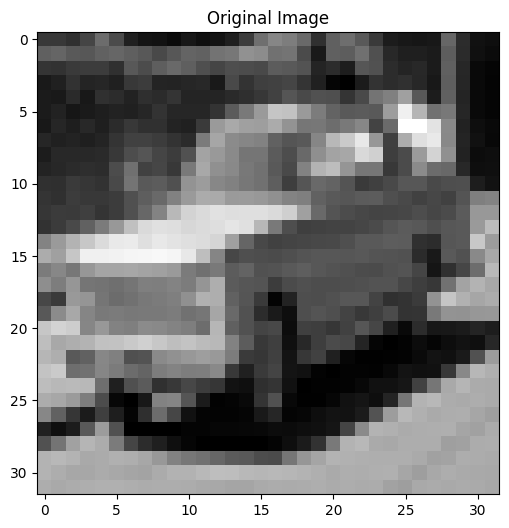

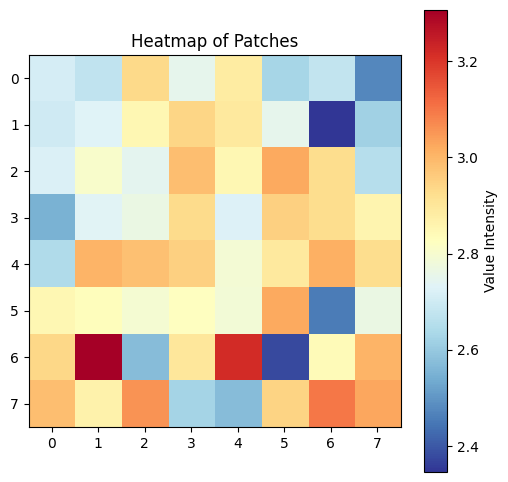

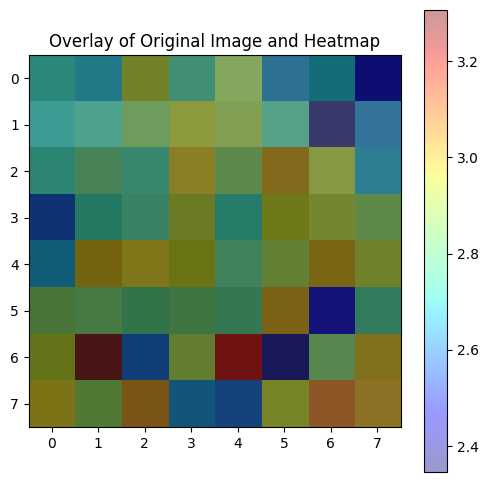

In [239]:
# Alternate cosine-sim visualization (same style as test_QVT_bi_patch... notebook)
import numpy as np
import matplotlib.pyplot as plt

def to_gray(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:
        return img
    if img.shape[2] == 1:
        return img[:, :, 0]
    weights = np.array([0.299, 0.587, 0.114], dtype=np.float32)
    return (img[:, :, :3] * weights).sum(axis=2)

def visualize_sample_and_heatmap(sample: np.ndarray, heatmap: np.ndarray, patch_shape=(2, 2)):
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title('Original Image')
    plt.show()

    # 2. Heatmap only
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(label='Value Intensity')
    plt.title('Heatmap of Patches')
    plt.show()

    # 3. Overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(heatmap, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title('Overlay of Original Image and Heatmap')
    plt.show()

# Example: visualize cosine map for a chosen layer
VIS_LAYER = 0  # 0-based
cos_map = cosine_score(intermediates[VIS_LAYER], use_output=False)
original_image = to_gray(img_np)
visualize_sample_and_heatmap(original_image, cos_map, patch_shape=(patch_rows, patch_cols))


In [ ]:
# QViT-style cosine map (length ratio * exp(cos)) weighted by class weights
import numpy as np
import matplotlib.pyplot as plt

VIS_LAYER = 0  # 0-based layer index
TARGET_CLASS = None  # set int class index; None -> use predicted class (if multi-class)
USE_OUTPUT = False  # False: use residual, True: use post-norm output

def visualize_sample_and_heatmap(sample: np.ndarray, heatmap: np.ndarray, patch_shape=(7, 7)):
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title('Original Image')
    plt.show()

    # 2. Heatmap only
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(label='Value Intensity')
    plt.title('Heatmap of Patches')
    plt.show()

    # 3. Overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(heatmap, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title('Overlay of Original Image and Heatmap')
    plt.show()

# Preconditions: concat aggregation, no hidden dims
if AGG_MODE != 'concat':
    raise RuntimeError("QViT-style weight heatmap assumes agg_mode='concat'.")
if HIDDEN_DIMS:
    raise RuntimeError("QViT-style weight heatmap assumes no hidden dims.")

# Pick class
with torch.no_grad():
    logits_out = logits
if isinstance(logits_out, (list, tuple)):
    logits_out = logits_out[0]
if NUM_CLASSES == 1:
    class_idx = 0
else:
    if TARGET_CLASS is None:
        class_idx = int(torch.argmax(logits_out, dim=-1).item())
    else:
        class_idx = int(TARGET_CLASS)

# Get classifier weights and reshape to [P, D]
weights = model.classifier.net[-1].weight  # [C, P*D] or [1, P*D]
w = weights[class_idx] if weights.dim() == 2 else weights
w = torch.clamp(w, min=0)
P = patch_rows * patch_cols
D = intermediates[VIS_LAYER]['input'].shape[-1]
if w.numel() != P * D:
    raise RuntimeError(f"Weight size {w.numel()} != P*D {P*D}. Check config.")
w_reshaped = w.view(P, D)

# Cosine score expanded to [P, D]
y1 = intermediates[VIS_LAYER]['input'][0]
y2 = intermediates[VIS_LAYER]['output'][0] if USE_OUTPUT else intermediates[VIS_LAYER]['residual'][0]
eps = 1e-12
length_ratio = y2.norm(dim=-1) / (y1.norm(dim=-1) + eps)
cos_sim = F.cosine_similarity(y1, y2, dim=-1)
expanded = (length_ratio * torch.exp(cos_sim)).unsqueeze(1).expand(-1, D)
unit_weight = expanded * w_reshaped  # [P, D]

# Build heatmap like QViT notebook (block of patch_h x patch_w if possible)
if D == patch_h * patch_w:
    patches = unit_weight.detach().cpu().numpy().reshape(P, patch_h, patch_w)
    heatmap = np.block([[patches[i * patch_cols + j] for j in range(patch_cols)] for i in range(patch_rows)])
else:
    # Fallback: reduce D to per-patch scalar and upscale to image size
    patch_scores = unit_weight.mean(dim=1).detach().cpu().numpy().reshape(patch_rows, patch_cols)
    heatmap = np.kron(patch_scores, np.ones((patch_h, patch_w)))

# Use grayscale base image like the QViT notebook
if img_np.ndim == 3 and img_np.shape[2] == 3:
    gray = (img_np[..., :3] * np.array([0.299, 0.587, 0.114], dtype=np.float32)).sum(axis=2)
else:
    gray = img_np.squeeze()

visualize_sample_and_heatmap(gray, heatmap, patch_shape=(patch_rows, patch_cols))


IndexError: index 3 is out of bounds for dimension 0 with size 1

picked label: 1 raw index: 5


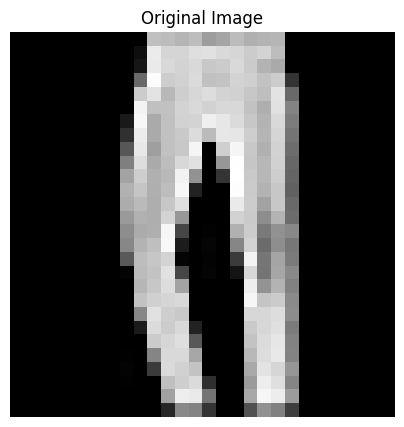

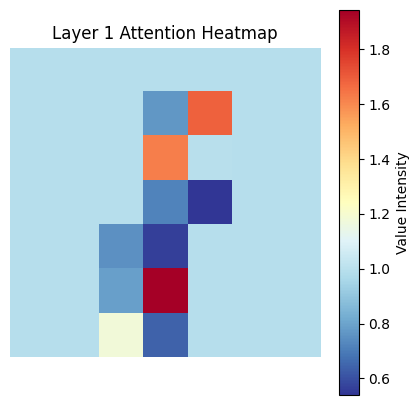

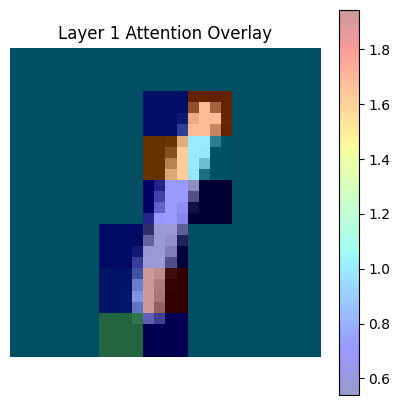

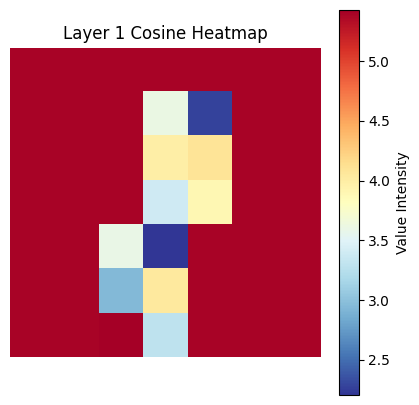

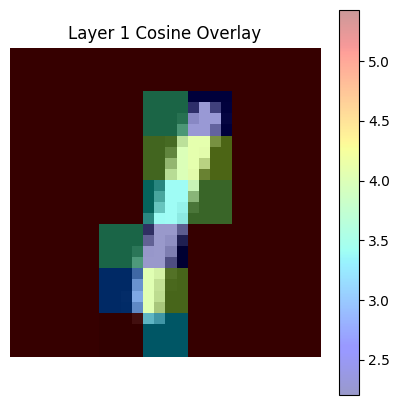

In [247]:
# One-cell runner: configure model + dataset, then show layerwise attention/cosine heatmaps (no saving)
import os
import sys
import importlib
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# ---- Config ----
PROJECT_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

MODEL_MODULE = "model"  # or 'model_revision'
CHECKPOINT_PATH = "/home/junyeollee/QSANN/codes/QSANN_revision/results/models/mnist[1-7]-n600-N1200-20251226-093646_best.pt"

DATASET_CHOICE = "mnist"  # 'mnist' | 'fmnist' | 'cifar10'
DATA_ROOT = "/home/junyeollee/QSANN/codes/QSANN_revision/data"
TARGET_LABELS = [1, 7]  # only pick from these classes
SAMPLE_INDEX = 2  # index within the filtered subset

IMAGE_SIZE = 28
PATCH_SIZE = 4
NUM_QUBITS = 8
VQC_LAYERS = 1
REUPLOADING = 2
MEASUREMENT = "correlations"  # or 'statevector'
BACKEND_DEVICE = "gpu"  # or 'cpu'
USE_TORCH_AUTOGRAD = True

QKV_MODE = "separate"  # 'shared' or 'separate'
QKV_DIM = 64
ATTN_LAYERS = 1
ATTN_TYPE = "rbf"  # 'dot' or 'rbf'
RBF_GAMMA = 1.0
AGG_MODE = "concat"  # 'concat' | 'gap_gmp' | 'attn_pool'
HIDDEN_DIMS = []  # e.g., [64], or [] for none
DROPOUT = 0.3
NUM_CLASSES = 1

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# ---- Load sample ----
if DATASET_CHOICE in ("mnist", "fmnist"):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
    if DATASET_CHOICE == "mnist":
        ds = datasets.MNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    else:
        ds = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, 1, H, W]
    print("picked label:", label, "raw index:", idx)
elif DATASET_CHOICE == "cifar10":
    CIFAR_GRAYSCALE = False  # set True to match grayscale training
    if CIFAR_GRAYSCALE:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
        ])
    ds = datasets.CIFAR10(root=DATA_ROOT, train=False, download=False, transform=transform)
    labels = [int(y) for _, y in ds]
    indices = [i for i, y in enumerate(labels) if y in TARGET_LABELS]
    if not indices:
        raise RuntimeError("No samples found for TARGET_LABELS.")
    idx = indices[SAMPLE_INDEX % len(indices)]
    img, label = ds[idx]
    sample_tensor = img.unsqueeze(0)  # [1, C, H, W]
    print("picked label:", label, "raw index:", idx)
else:
    raise ValueError("DATASET_CHOICE must be 'mnist', 'fmnist', or 'cifar10'.")

# ---- Build model ----
if isinstance(PATCH_SIZE, (tuple, list)):
    patch_h, patch_w = int(PATCH_SIZE[0]), int(PATCH_SIZE[1])
else:
    patch_h = patch_w = int(PATCH_SIZE)
if IMAGE_SIZE % patch_h != 0 or IMAGE_SIZE % patch_w != 0:
    raise ValueError("IMAGE_SIZE must be divisible by PATCH_SIZE.")

channels = int(sample_tensor.shape[1])
data_dim = channels * patch_h * patch_w

mod = importlib.import_module(MODEL_MODULE)
QuantumAnsatz = getattr(mod, "QuantumAnsatz")
HybridQuantumClassifier = getattr(mod, "HybridQuantumClassifier")

ansatz = QuantumAnsatz(
    data_dim=data_dim,
    num_qubits=NUM_QUBITS,
    vqc_layers=VQC_LAYERS,
    reuploading=REUPLOADING,
    measurement=MEASUREMENT,
    backend_device=BACKEND_DEVICE,
    use_torch_autograd=USE_TORCH_AUTOGRAD,
)

if QKV_MODE == "shared":
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )
else:
    ansatz_k = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    ansatz_v = QuantumAnsatz(
        data_dim=data_dim,
        num_qubits=NUM_QUBITS,
        vqc_layers=VQC_LAYERS,
        reuploading=REUPLOADING,
        measurement=MEASUREMENT,
        backend_device=BACKEND_DEVICE,
        use_torch_autograd=USE_TORCH_AUTOGRAD,
    )
    model = HybridQuantumClassifier(
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        ansatz=ansatz,
        ansatz_k=ansatz_k,
        ansatz_v=ansatz_v,
        q_dim=QKV_DIM,
        k_dim=QKV_DIM,
        v_dim=QKV_DIM,
        attn_layers=ATTN_LAYERS,
        attn_type=ATTN_TYPE,
        rbf_gamma=RBF_GAMMA,
        agg_mode=AGG_MODE,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        device=DEVICE,
        qkv_mode=QKV_MODE,
        num_classes=NUM_CLASSES,
    )

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
state_dict = ckpt.get("state_dict") or ckpt.get("model_state_dict") or ckpt if isinstance(ckpt, dict) else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()

# ---- Inference ----
sample_tensor = sample_tensor.to(DEVICE)
with torch.no_grad():
    logits, attn_stats, weights_list, intermediates = model(
        sample_tensor, return_attention=True, return_intermediates=True
    )

# ---- Helpers ----
def attention_heatmap(weights: torch.Tensor) -> np.ndarray:
    heat = weights.sum(dim=0).cpu().numpy()
    return heat.reshape(patch_rows, patch_cols)

def cosine_score(intermediate: dict, use_output: bool = False) -> np.ndarray:
    y1 = intermediate["input"][0]
    y2 = intermediate["output"][0] if use_output else intermediate["residual"][0]
    eps = 1e-12
    length_ratio = y2.norm(dim=-1) / (y1.norm(dim=-1) + eps)
    cos_sim = F.cosine_similarity(y1, y2, dim=-1)
    score = length_ratio * torch.exp(cos_sim)
    return score.cpu().numpy().reshape(patch_rows, patch_cols)

def show_heatmap_and_overlay(base: np.ndarray, heatmap: np.ndarray, title_prefix: str) -> None:
    # heatmap only
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, cmap='RdYlBu_r', interpolation='nearest')
    plt.colorbar(label='Value Intensity')
    plt.title(f"{title_prefix} Heatmap")
    plt.axis('off')
    plt.show()

    # overlay
    heat_up = np.kron(heatmap, np.ones((patch_h, patch_w)))
    plt.figure(figsize=(5, 5))
    if base.ndim == 2:
        plt.imshow(base, cmap='gray', interpolation='none')
    else:
        plt.imshow(base, interpolation='none')
    plt.imshow(heat_up, cmap='jet', alpha=0.4, interpolation='none')
    plt.colorbar()
    plt.title(f"{title_prefix} Overlay")
    plt.axis('off')
    plt.show()

# ---- Display ----
plt.figure(figsize=(5, 5))
if base_img.ndim == 2:
    plt.imshow(base_img, cmap='gray', interpolation='none')
else:
    plt.imshow(base_img, interpolation='none')
plt.title('Original Image')
plt.axis('off')
plt.show()

patch_rows = IMAGE_SIZE // patch_h
patch_cols = IMAGE_SIZE // patch_w

img = sample_tensor[0].detach().cpu()
if img.shape[0] == 1:
    base_img = img[0].numpy()
else:
    base_img = img.permute(1, 2, 0).numpy()
base_img = np.clip(base_img, 0.0, 1.0)

for i, weights in enumerate(weights_list):
    attn_map = attention_heatmap(weights[0])
    show_heatmap_and_overlay(base_img, attn_map, f"Layer {i+1} Attention")

for i, inter in enumerate(intermediates):
    cos_map = cosine_score(inter, use_output=False)
    show_heatmap_and_overlay(base_img, cos_map, f"Layer {i+1} Cosine")
